<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/notebooks/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №6

# Задание



Необходимо сгенерировать синтетические данные и обучить на них модель авторегрессии, модель LSTM.

Обучить рекуррентную нейронную сеть на реальных данных погоды по варианту.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы. Результаты моделей авторегрессии, LSTM на систетических данных, а также результаты обучения на реальных данных.

Вариант города соответствует группе: 1 - Москва, 2 - Санкт-Петербург, 3 - Новосибирск, 4 - Екатеринбург

# Задания для самостоятельной работы
1. Проведите обучение трех моделей по вашему варианту для вашего города.
2. Измените гиперпараметры обучения для улучшения модели: количество эпох, размер батча, скорость обучения
3. Создайте два варианта синтетических данных: первый вариант только сезонная компонента и шум; второй вариант только меняющийся тренд и шум
4. Измените конфигурацию нейросети: оставьте одну однонаправленную ячейку LSTM с выходным полносвязным слоем. Обучите ее на новых синтетических данных и сравните 3 разных варианта размерности состояния ячейки.
5. Укажите, какие действия помогли улучшить метрики ваших моделей и объясните почему.
6. Укажите в отчете как меняется количество обучаемых в LSTM параметров при изменении ее конфигурации

# Контрольные вопросы
1. Что такое временной ряд
2. Формула авторегрессии
3. Что такое рекуррентная нейронная сеть?
4. Отличия LSTM и GRU
5. Что такое вентиль? Какие вентили есть в LSTM?
6. Размерность входных, выходных данных и состояния для LSTM
7. Что такое двунаправленная LSTM?
8. Модель seq2seq
9. Генерация текста с помощью RNN

# Импорт библиотек

In [1]:
#!pip install torchsummary
import time
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Часть 1 (Синтетические данные)

## Генерация данных

### Меняющаяся сезонная компонента

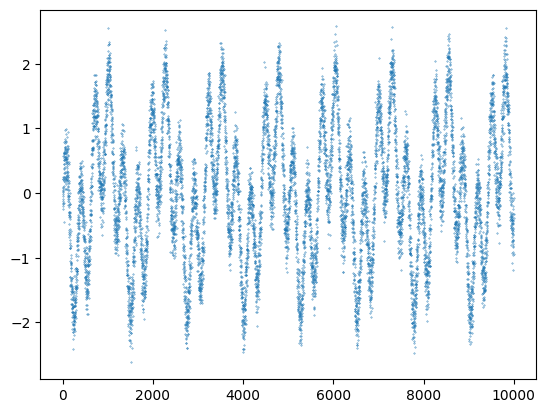

In [3]:
X = np.arange(10000)
y = np.sin(X/50)-np.sin(X/200)
y += np.random.normal(scale=0.25, size=y.size)
plt.scatter(X, y[:10000], s=0.1)

df = pd.Series(y)
df = df.diff().dropna()

### Меняющийся тренд

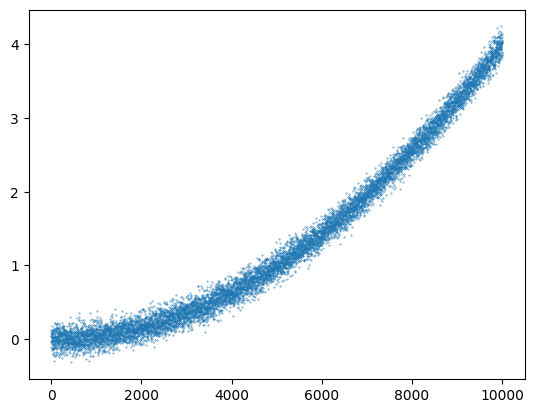

In [4]:
# y2 = np.cos(X)*np.sin(2*np.pi*X)+np.sin(np.pi*X**2)
y = (2*X/X.size)**2
y += np.random.normal(scale=0.1, size=y.size)
plt.scatter(X, y[:10000], s=0.1)

df = pd.Series(y)

In [5]:
def getWindows(x):
    X.append(x.values.copy())
    return 0

WINDOW_SIZE = 200
X = []
df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
X = np.array(X)
y = X[:, WINDOW_SIZE:].copy()
X = X[:, :WINDOW_SIZE].copy()
X.shape, y.shape

((9800, 200), (9800, 1))

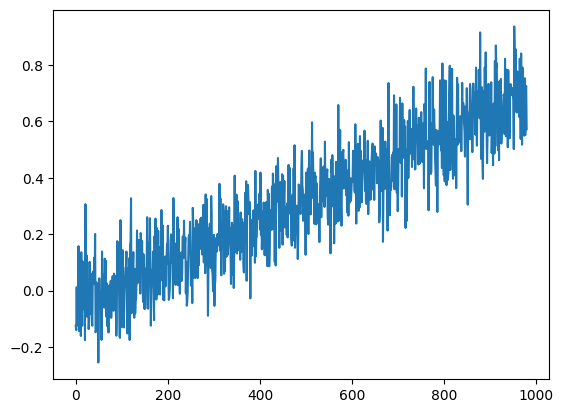

In [6]:
X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()
y_train -= X_train[:, -1:]
X_train = np.diff(X_train)

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()
y_test -= X_test[:, -1:]
X_test = np.diff(X_test)

plt.plot(np.cumsum(y_test))

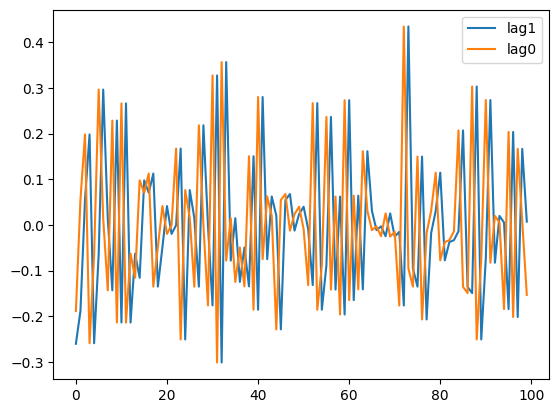

In [7]:
plt.plot(X_test[-100:,-1], label='lag1')
plt.plot(y_test[-100:], label='lag0')
plt.legend()

## Модель авторегрессии (AR)

In [8]:
def time_series_score(y_true, y_pred, X_true, previous_cnt=1):
    true_values = y_true#X_true[:, -1] + y_true
    pred_values = y_pred#X_true[:, -1] + y_pred

    last_value = X_true[:,-previous_cnt:].mean(axis=-1)
    variance_dummy = ((last_value - true_values)**2).mean()
    variance_pred = ((pred_values - true_values)**2).mean()
    #print(variance_dummy, variance_pred)
    r2 = 1 - variance_pred/variance_dummy
    #r2_adj = 1 - (1-r2)*(y_true.size - 1)/(y_true.size - X_true.shape[1] - 1)
    return r2

def recursive_predict(model, X):
    preds = []
    length = X.shape[0]
    last_vals = X[0].copy()
    for i in range(length):
        preds.append(model.predict([last_vals]))
        #tmp = last_vals[-1].copy()
        last_vals[:-1] = last_vals[1:]
        last_vals[-1:] = preds[-1] # + tmp
    return np.array(preds).reshape(-1)

  0%|          | 0/40 [00:00<?, ?it/s]

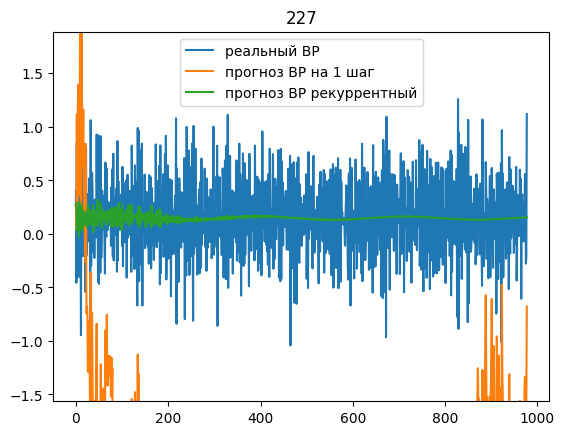

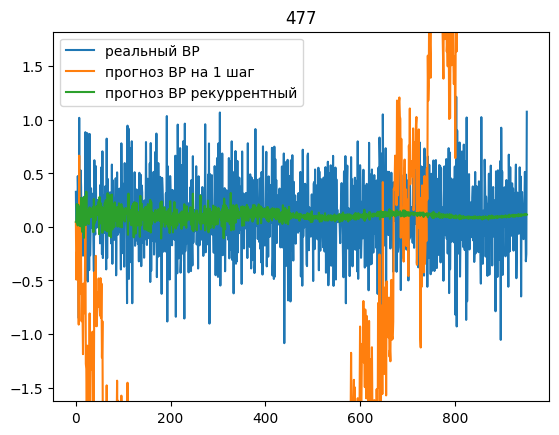

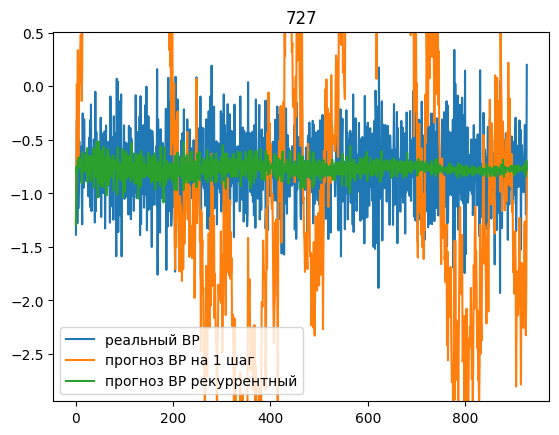

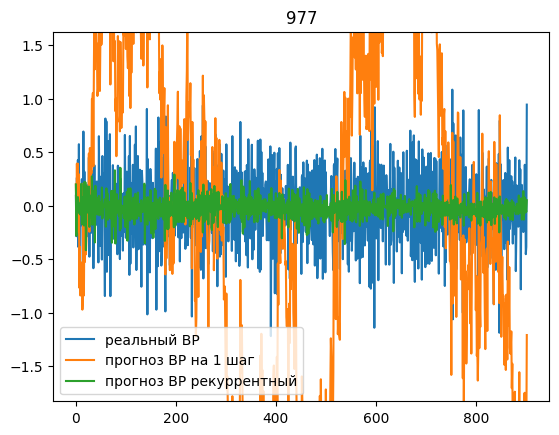

In [9]:
stats = []
series = []

windows = np.arange(2, 1001, 25)
for w in tqdm(windows):
    WINDOW_SIZE = w
    X = []
    df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
    X = np.array(X)
    y = X[:, WINDOW_SIZE:].copy()
    X = X[:, :WINDOW_SIZE].copy()

    X_train = X[:X.shape[0]*9//10].copy()
    y_train = y[:y.shape[0]*9//10].copy()
    y_train -= X_train[:, -1:]
    X_train = np.diff(X_train)

    X_test = X[X.shape[0]*9//10:].copy()
    y_test = y[y.shape[0]*9//10:].copy()
    y_test -= X_test[:, -1:]
    X_test = np.diff(X_test)

    lr = LinearRegression().fit(X_train, y_train)

    #preds = lr.predict(X_test)
    #preds = recursive_predict(lr, X_test)
    tmp = []
    p = [lr.predict(X_test), recursive_predict(lr, X_test)]
    for preds in p:
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        tss = time_series_score(y_test, preds, X_test)
        tmp.extend([mae, r2*100, tss*100])
    stats.append(tmp)
    series.append(p)
    if (len(stats)%10)==0:
        plt.plot(np.cumsum(y_test), label='реальный ВР')
        plt.plot(np.cumsum(p[0]), label='прогноз ВР на 1 шаг')
        plt.plot(np.cumsum(p[1]), label='прогноз ВР рекуррентный')
        plt.title(str(WINDOW_SIZE))
        plt.ylim(np.cumsum(y_test).min()*1.5, np.cumsum(y_test).max()*1.5)
        plt.legend(loc=0)
        plt.show()

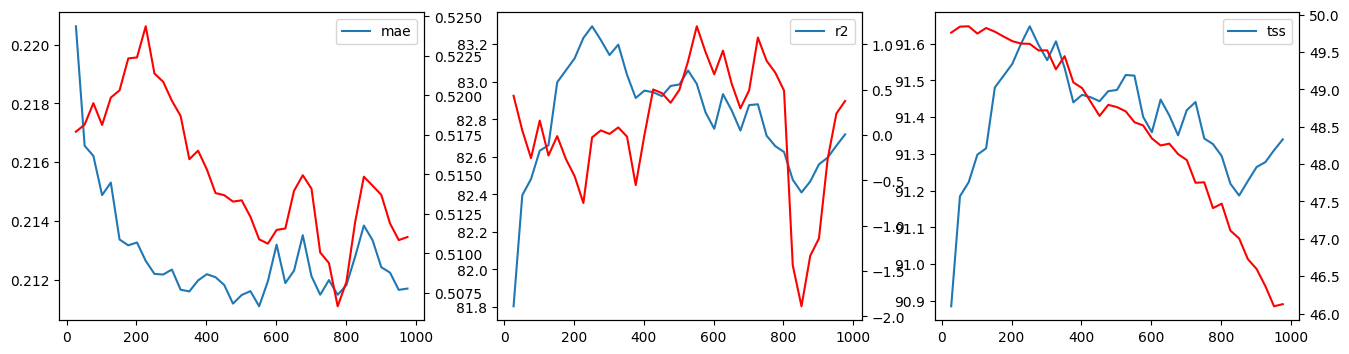

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(windows[1:], np.array(stats)[1:,0], label='mae')
ax[1].plot(windows[1:], np.array(stats)[1:,1], label='r2')
ax[2].plot(windows[1:], np.array(stats)[1:,2], label='tss')

ax[0].twinx().plot(windows[1:], np.array(stats)[1:,3], c='r', label='mae rec')
ax[1].twinx().plot(windows[1:], np.array(stats)[1:,4], c='r', label='r2 rec')
ax[2].twinx().plot(windows[1:], np.array(stats)[1:,5], c='r', label='tss rec')

for ax_ in ax:
    ax_.legend()

AR RMSE: 0.266	Naive RMSE: 0.646


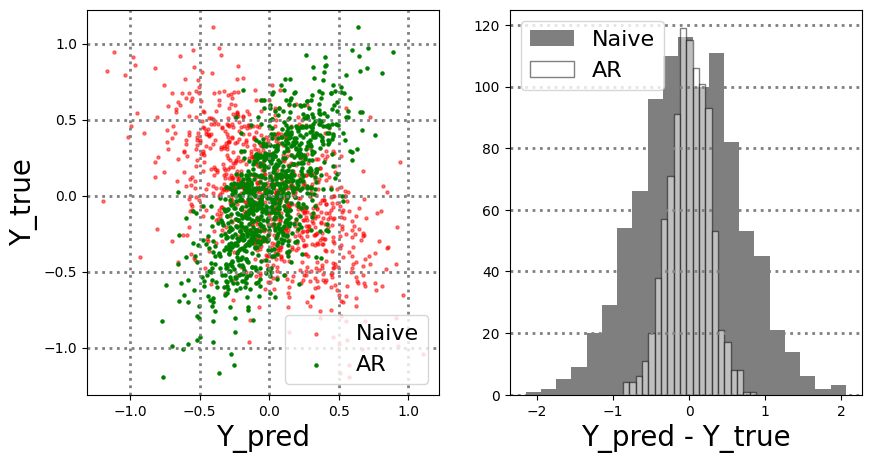

In [11]:
idx = np.array(stats)[:, 0].argmin()
WINDOW_SIZE = windows[idx]
X = []
df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
X = np.array(X)
y = X[:, WINDOW_SIZE:].copy()
X = X[:, :WINDOW_SIZE].copy()

X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()
y_train -= X_train[:, -1:]
X_train = np.diff(X_train)

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()
y_test -= X_test[:, -1:]
X_test = np.diff(X_test)

preds_ar = X[X.shape[0]*9//10:, -1] + series[idx][0].flatten()
preds_naive = X[X.shape[0]*9//10:, -1:].mean(axis=1)
y_true = y[y.shape[0]*9//10:].flatten()
err_ar = y_true - preds_ar
err_naive = y_true - preds_naive

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    preds_naive,
    y_true,
    s=5,
    facecolor='red',
    alpha=0.5,
    label='Naive'
)
ax[0].scatter(
    preds_ar,
    y_true,
    s=5,
    facecolor='green',
    alpha=1,
    label='AR'
)
ax[1].hist(err_naive,
         bins=21,
         facecolor='k',
         alpha=0.5,
         label='Naive')
ax[1].hist(err_ar,
         bins=21,
         edgecolor='k',
         facecolor='w',
         alpha=0.5,
         label='AR')

ax[0].set_xlabel('Y_pred', fontsize=20)
ax[0].set_ylabel('Y_true', fontsize=20)
ax[1].set_xlabel('Y_pred - Y_true', fontsize=20)
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[0].grid(axis='both', linestyle=':', linewidth=2, color='gray')
ax[1].grid(axis='y', linestyle=':', linewidth=2, color='gray')

print('AR RMSE: %.3f\tNaive RMSE: %.3f'%(err_ar.std(), err_naive.std()))

## LSTM

In [78]:
WINDOW_SIZE = 750
X = []
df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
X = np.array(X)
y = X[:, WINDOW_SIZE:].copy()
X = X[:, :WINDOW_SIZE].copy()
X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()
y_train -= X_train[:, -1:]
X_train = np.diff(X_train)

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()
y_test -= X_test[:, -1:]
X_test = np.diff(X_test)

In [79]:
#MAX_VAL = np.abs(y_train).max()
tensor_X_train = torch.autograd.Variable(torch.Tensor(X_train))
tensor_y_train = torch.autograd.Variable(torch.Tensor(y_train))

tensor_X_test = torch.autograd.Variable(torch.Tensor(X_test))
tensor_y_test = torch.autograd.Variable(torch.Tensor(y_test))

dataset = TensorDataset(tensor_X_train, tensor_y_train)

dataset_test = TensorDataset(tensor_X_test, tensor_y_test)

dataloader = {}
dataloader['train'] = DataLoader(dataset, batch_size=512, shuffle=False)
dataloader['test'] = DataLoader(dataset_test, batch_size=128, shuffle=False)
del dataset, dataset_test

In [99]:
class LSTM(nn.Module):

    def __init__(self, num_features, input_size, hidden_size, num_layers,
                 bidirectional=True, p=0.4):
        super(LSTM, self).__init__()

        self.num_features = num_features
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.fc = nn.Linear(2*hidden_size if bidirectional else hidden_size, 1)

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            batch_first=True)

        self.dropout = nn.Dropout(p)

        self.fc = nn.Linear(2*hidden_size if bidirectional else hidden_size, 1)


    def init_hidden(self, dim, device):
        h_0 = torch.autograd.Variable(
            torch.zeros(
                2*self.num_layers if self.bidirectional else self.num_layers,
                dim,
                self.hidden_size,
                device=device
            )
        )

        c_0 = torch.autograd.Variable(
            torch.zeros(
                2*self.num_layers if self.bidirectional else self.num_layers,
                dim,
                self.hidden_size,
                device=device
            )
        )
        return (h_0, c_0)


    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(x.size(0), x.device)

        # Propagate input through LSTM
        lstm_out, hidden = self.lstm(x.view(x.size(0), x.size(1), 1), hidden)
        lstm_out = lstm_out[:, -1, :]
        #print(lstm_out.shape, [h.shape for h in hidden])
        h_out = lstm_out.view(x.size(0), -1)

        out = self.fc(self.dropout(h_out))

        return out, hidden

In [100]:
learning_rate = 0.01

num_features = 1
input_size = 1
hidden_size = 16
num_layers = 1
bidirectional = True
dropout_rate = 0.2

model = LSTM(
    num_features,
    input_size,
    hidden_size,
    num_layers,
    bidirectional,
    dropout_rate
).to(device)

criterion = torch.nn.MSELoss()    # среднекврадратическое отклонение
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# добавляем постепенное уменьшение шага обучения каждые 15 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [101]:
for name, weight in model.named_parameters():
    print(name, weight.shape)

lstm.weight_ih_l0 torch.Size([64, 1])
lstm.weight_hh_l0 torch.Size([64, 16])
lstm.bias_ih_l0 torch.Size([64])
lstm.bias_hh_l0 torch.Size([64])
lstm.weight_ih_l0_reverse torch.Size([64, 1])
lstm.weight_hh_l0_reverse torch.Size([64, 16])
lstm.bias_ih_l0_reverse torch.Size([64])
lstm.bias_hh_l0_reverse torch.Size([64])
fc.weight torch.Size([1, 32])
fc.bias torch.Size([1])


Эпоха: 10
Лучшее значение функции потерь: 0.010528804617933929
Текущее значение функции потерь: 0.011826189700514078


  0%|          | 0/170 [00:00<?, ?it/s]

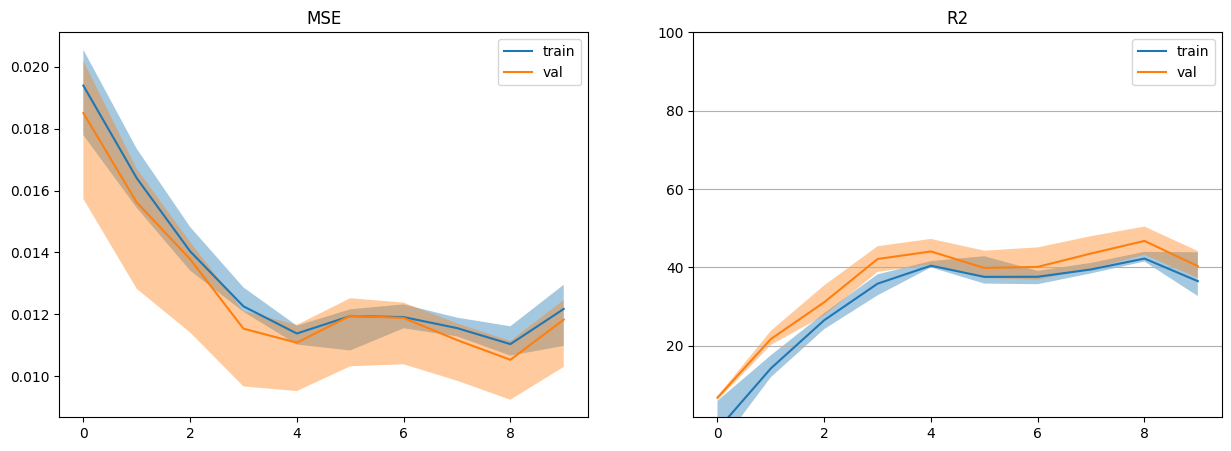

Обучение закончено за 129.53522992134094 секунд


In [102]:
EPOCHS = 10
REDRAW_EVERY = 1
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_loss = np.inf
checkpoint_path = 'ts.pth'
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    model.train()
    hidden = None
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = [xx.to(device) for xx in batch]

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        if hidden is not None and inputs.shape[0] != hidden[0].shape[1]:
            print(inputs.shape[0], hidden[0].shape[1])
            hidden = None
        outputs, hidden = model(inputs, hidden)
        hidden = tuple([e.data for e in hidden])
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        # обрезка градиентов
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # обновление параметров модели
        optimizer.step()

        # для подсчёта статистик
        accuracy = 100*r2_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        tmp.append((loss.item(), accuracy))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    model.eval()
    hidden = None
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            if hidden is not None and inputs.shape[0] != hidden[0].shape[1]:
                print(inputs.shape[0], hidden[0].shape[1])
                hidden = None
            outputs, hidden = model(inputs, hidden)
            hidden = tuple([e.data for e in hidden])
            loss = criterion(outputs, labels)
            accuracy = 100*r2_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            tmp.append((loss.item(), accuracy))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    loss = losses_val[-1][0][0]
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшее значение функции потерь: %s\n'
          'Текущее значение функции потерь: %s' % (epoch+1, best_loss, loss))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['MSE', 'R2']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

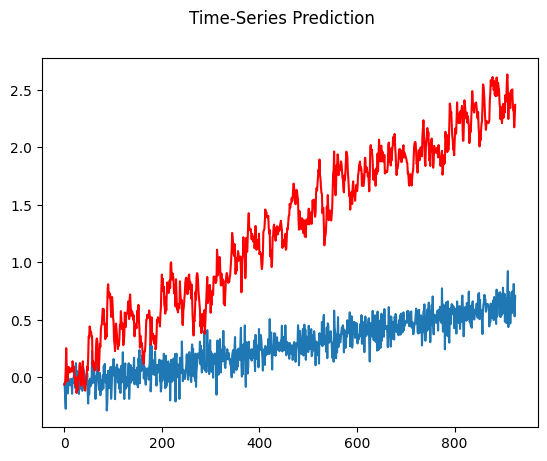

In [103]:
model.eval()
train_predict, _ = model(tensor_X_test.to(device))

data_predict = train_predict.data.cpu().numpy()#*MAX_VAL
dataY_plot = tensor_y_test.data.cpu().numpy()#*MAX_VAL

plt.plot(np.cumsum(dataY_plot))
plt.plot(np.cumsum(data_predict), color='r')
plt.suptitle('Time-Series Prediction')
plt.show()

LSTM RMSE: 0.100	Naive RMSE: 0.137


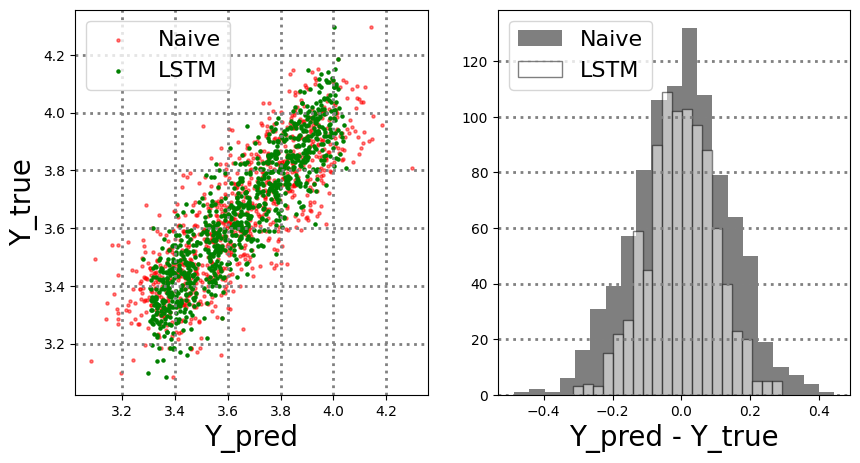

In [104]:
preds_ar = X[X.shape[0]*9//10:, -1] + data_predict.flatten()
preds_naive = X[X.shape[0]*9//10:, -1:].mean(axis=1)
y_true = y[y.shape[0]*9//10:].flatten()
err_ar = y_true - preds_ar
err_naive = y_true - preds_naive

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    preds_naive,
    y_true,
    s=5,
    facecolor='red',
    alpha=0.5,
    label='Naive'
)
ax[0].scatter(
    preds_ar,
    y_true,
    s=5,
    facecolor='green',
    alpha=1,
    label='LSTM'
)
ax[1].hist(err_naive,
         bins=21,
         facecolor='k',
         alpha=0.5,
         label='Naive')
ax[1].hist(err_ar,
         bins=21,
         edgecolor='k',
         facecolor='w',
         alpha=0.5,
         label='LSTM')

ax[0].set_xlabel('Y_pred', fontsize=20)
ax[0].set_ylabel('Y_true', fontsize=20)
ax[1].set_xlabel('Y_pred - Y_true', fontsize=20)
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[0].grid(axis='both', linestyle=':', linewidth=2, color='gray')
ax[1].grid(axis='y', linestyle=':', linewidth=2, color='gray')

print('LSTM RMSE: %.3f\tNaive RMSE: %.3f'%(err_ar.std(), err_naive.std()))

  0%|          | 0/925 [00:00<?, ?it/s]

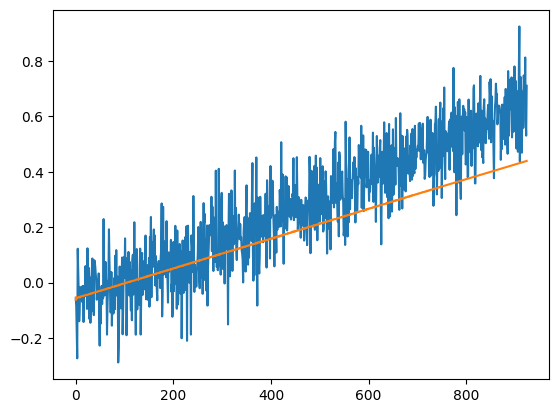

In [105]:
# Рекуррентный прогноз
model.eval()
last_value = tensor_X_test[0].clone()
preds = []
hidden = None
with torch.no_grad():
    for i in tqdm(range(y_test.shape[0])):
        output, hidden = model(last_value.view(1, last_value.size(-1)).to(device), hidden)
        hidden = tuple([e.data for e in hidden])
        preds.append(output.detach().cpu().item())
        last_value[:-1] = last_value[1:].clone()
        last_value[-1:] = preds[-1]
preds = np.array(preds)# * MAX_VAL
plt.plot(np.cumsum(y_test))
plt.plot(np.cumsum(preds))

In [107]:
print('='*50)
print('#', 'Тип', 'Кол-во точек', 'R2, %', 'TSS, %', sep='\t')
for p, label in zip([data_predict, preds], ['one-step', 'recursive']):
    for front in [2, 3, 5, 10, 50, -1]:
        print('#',
              label,
              front,
              '%.2f'%(r2_score(y_test[:front],
                               p[:front])*100),
              '%.2f'%(time_series_score(y_test[:front],
                                        p[:front],
                                        X_test[:front],
                                        previous_cnt=3)*100),
              sep='\t')
    print('='*50)

#	Тип	Кол-во точек	R2, %	TSS, %
#	one-step	2	-374.85	83.98
#	one-step	3	-775.77	34.96
#	one-step	5	42.32	48.02
#	one-step	10	40.84	50.20
#	one-step	50	39.80	47.47
#	one-step	-1	46.59	51.67
#	recursive	2	-547.82	57.42
#	recursive	3	-418.13	59.36
#	recursive	5	0.22	4.94
#	recursive	10	1.27	14.29
#	recursive	50	0.34	12.05
#	recursive	-1	-0.04	9.49


# Часть 2 (Реальные данные)

In [108]:
!gdown --folder https://drive.google.com/drive/folders/1FtEVU702DjlTjoecxbbNBl5nP9SCu7Rw

Processing file 1mBIyf4Zo4ChrQ0R6EvwdrkQzrAKpX27c climate_ekb.csv
Processing file 1B0RgTX4TN8WuLkXins8D1pnrdhntHPXQ climate_moscow.csv
Processing file 18AVqfU6mtCwuqkuC6feZs9slE-WJk9MU climate_novosib.csv
Processing file 12SudJ27Zzxrd2eg4wsMDrfDQMTkacuFL climate_piter.csv
Building directory structure completed


Retrieving folder list
Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1mBIyf4Zo4ChrQ0R6EvwdrkQzrAKpX27c
To: g:\repos\Deep-learning\6 lab\climate\climate_ekb.csv

  0%|          | 0.00/3.75M [00:00<?, ?B/s]
 56%|█████▌    | 2.10M/3.75M [00:00<00:00, 19.5MB/s]
100%|██████████| 3.75M/3.75M [00:00<00:00, 22.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B0RgTX4TN8WuLkXins8D1pnrdhntHPXQ
To: g:\repos\Deep-learning\6 lab\climate\climate_moscow.csv

  0%|          | 0.00/3.70M [00:00<?, ?B/s]
 28%|██▊       | 1.05M/3.70M [00:00<00:00, 9.00MB/s]
100%|██████████| 3.70M/3.70M [00:00<00:00, 22.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=18AVqfU6mtCwuqkuC6feZs9slE-WJk9MU
To: g:\repos\Deep-learning\6 lab\climate\climate_novosib.csv

  0%|          | 0.00/3.73M [00:00<?, ?B/s]
 28%|██▊       | 1.05M/3.73M [00:00<00:00, 9.97MB/s]
100%|██████████| 3.73M/3.73M [00:00<00:00, 25.5MB/s]
Downloading...
From: https

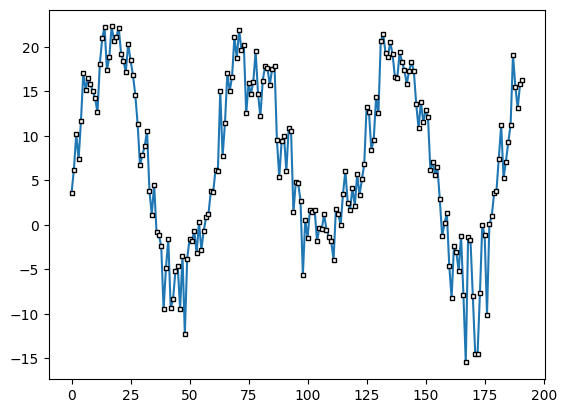

In [8]:
# По варианту проделать те же шаги для набора данных с погодой за полвека
df = pd.read_csv('climate/climate_moscow.csv', sep='\t')
df = df[df.year>1972].copy()
df['quartile'] = df.day//7
plt.plot(
    df.groupby(['year', 'month', 'quartile'])
      .Temperature
      .aggregate('mean')
      .iloc[-4*12*4:]
      .reset_index()
      .Temperature,
   #rot=90,
   #ylabel='temperature',
   marker='s',
   markersize=3,
   markerfacecolor='white',
   markeredgecolor='k'
)
df = df.Temperature.diff().dropna()


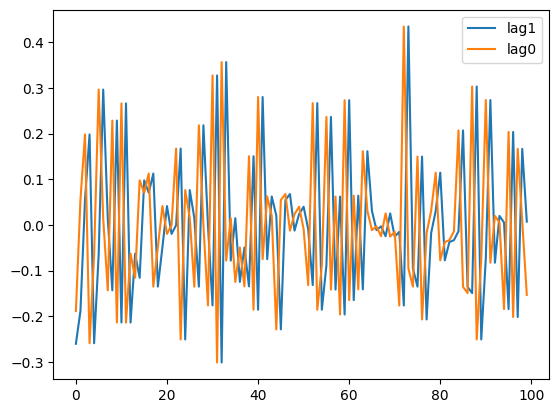

In [9]:
plt.plot(X_test[-100:,-1], label='lag1')
plt.plot(y_test[-100:], label='lag0')
plt.legend()

In [10]:
WINDOW_SIZE = 750
X = []
df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
X = np.array(X)
y = X[:, WINDOW_SIZE:].copy()
X = X[:, :WINDOW_SIZE].copy()
X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()
y_train -= X_train[:, -1:]
X_train = np.diff(X_train)

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()
y_test -= X_test[:, -1:]
X_test = np.diff(X_test)

In [11]:
#MAX_VAL = np.abs(y_train).max()
tensor_X_train = torch.autograd.Variable(torch.Tensor(X_train))
tensor_y_train = torch.autograd.Variable(torch.Tensor(y_train))

tensor_X_test = torch.autograd.Variable(torch.Tensor(X_test))
tensor_y_test = torch.autograd.Variable(torch.Tensor(y_test))

dataset = TensorDataset(tensor_X_train, tensor_y_train)

dataset_test = TensorDataset(tensor_X_test, tensor_y_test)

dataloader = {}
dataloader['train'] = DataLoader(dataset, batch_size=512, shuffle=False)
dataloader['test'] = DataLoader(dataset_test, batch_size=128, shuffle=False)
del dataset, dataset_test

In [12]:
class LSTM(nn.Module):

    def __init__(self, num_features, input_size, hidden_size, num_layers,
                 bidirectional=True, p=0.4):
        super(LSTM, self).__init__()

        self.num_features = num_features
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.fc = nn.Linear(2*hidden_size if bidirectional else hidden_size, 1)

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            batch_first=True)

        self.dropout = nn.Dropout(p)

        self.fc = nn.Linear(2*hidden_size if bidirectional else hidden_size, 1)


    def init_hidden(self, dim, device):
        h_0 = torch.autograd.Variable(
            torch.zeros(
                2*self.num_layers if self.bidirectional else self.num_layers,
                dim,
                self.hidden_size,
                device=device
            )
        )

        c_0 = torch.autograd.Variable(
            torch.zeros(
                2*self.num_layers if self.bidirectional else self.num_layers,
                dim,
                self.hidden_size,
                device=device
            )
        )
        return (h_0, c_0)


    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(x.size(0), x.device)

        # Propagate input through LSTM
        lstm_out, hidden = self.lstm(x.view(x.size(0), x.size(1), 1), hidden)
        lstm_out = lstm_out[:, -1, :]
        #print(lstm_out.shape, [h.shape for h in hidden])
        h_out = lstm_out.view(x.size(0), -1)

        out = self.fc(self.dropout(h_out))

        return out, hidden

In [14]:
learning_rate = 0.01

num_features = 1
input_size = 1
hidden_size = 16
num_layers = 1
bidirectional = False
dropout_rate = 0.2

model = LSTM(
    num_features,
    input_size,
    hidden_size,
    num_layers,
    bidirectional,
    dropout_rate
).to(device)

criterion = torch.nn.MSELoss()    # среднекврадратическое отклонение
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# добавляем постепенное уменьшение шага обучения каждые 15 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

for name, weight in model.named_parameters():
    print(name, weight.shape)

lstm.weight_ih_l0 torch.Size([64, 1])
lstm.weight_hh_l0 torch.Size([64, 16])
lstm.bias_ih_l0 torch.Size([64])
lstm.bias_hh_l0 torch.Size([64])
fc.weight torch.Size([1, 16])
fc.bias torch.Size([1])


Эпоха: 40
Лучшее значение функции потерь: 6.2898459775107245
Текущее значение функции потерь: 6.300517422812326


  0%|          | 0/1200 [00:00<?, ?it/s]

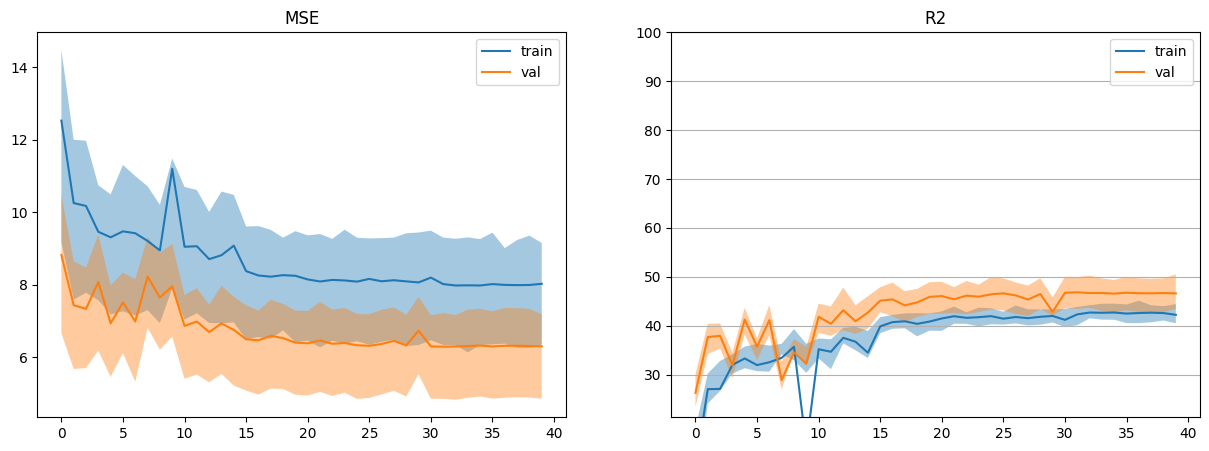

Обучение закончено за 378.2732000350952 секунд


In [15]:
EPOCHS = 40
REDRAW_EVERY = 1
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_loss = np.inf
checkpoint_path = 'ts.pth'
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    model.train()
    hidden = None
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = [xx.to(device) for xx in batch]

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        if hidden is not None and inputs.shape[0] != hidden[0].shape[1]:
            print(inputs.shape[0], hidden[0].shape[1])
            hidden = None
        outputs, hidden = model(inputs, hidden)
        hidden = tuple([e.data for e in hidden])
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        # обрезка градиентов
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # обновление параметров модели
        optimizer.step()

        # для подсчёта статистик
        accuracy = 100*r2_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        tmp.append((loss.item(), accuracy))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    model.eval()
    hidden = None
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            if hidden is not None and inputs.shape[0] != hidden[0].shape[1]:
                print(inputs.shape[0], hidden[0].shape[1])
                hidden = None
            outputs, hidden = model(inputs, hidden)
            hidden = tuple([e.data for e in hidden])
            loss = criterion(outputs, labels)
            accuracy = 100*r2_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            tmp.append((loss.item(), accuracy))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    loss = losses_val[-1][0][0]
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшее значение функции потерь: %s\n'
          'Текущее значение функции потерь: %s' % (epoch+1, best_loss, loss))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['MSE', 'R2']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)